# Hadoop Assignment
Rafaila Galanopoulou 8160018 \
Big Data Management Systems Course 2020 \
Professor: Damianos Chatziantoniou 

## 1. Installation Phase

Firstly, hadoop should be installed in one's local machine. It was suggested to install Cloudera distribution. My local machine runs Linux Mint 19.3.1 and the 2.6.0-cdh5.5.1 has been installed, based on this [tutorial](https://data-flair.training/blogs/install-yarn-with-hadoop-2/). A new user hduser has been created for the purposes of current assignment. It was preferrable for HDFS not to have access to all of our personal dire

![Hadoop has been successfully installed](images/hadoopinstalled.png)

## 2. Dataset Creation

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

In [46]:
centers=[(-2.5, -2.5),(2, 2), (10.5, 10.5)]
X,_= make_blobs(n_samples=[100000,500000,900000],
                   centers=centers,
                    cluster_std=0.2,
                    random_state=13)

We created out data using ` make_blobs() ` of sklearn API, which generates isotropic Gaussian blobs for clustering. The n_samples shows that generated data are unequally distruibuted and random state equals to an integer, in order to generate the same data independendly of how many times `make_blobs()` will be exucated. 

In [48]:
data = pd.DataFrame({
    'x': X[:, 0],
    'y': X[:, -1]
})


In [49]:
df.describe()

,x,y
count,1.500000e+06,1.500000e+06
mean,6.799518e+00,6.800190e+00
std,4.761081e+00,4.760628e+00
min,-7.206426e+00,-7.209408e+00
25%,2.122786e+00,2.126656e+00
50%,9.532079e+00,9.533309e+00
75%,1.071013e+01,1.071114e+01
max,1.539978e+01,1.565255e+01


In [50]:
df=df.rename(columns={0:'x',1:'y'})

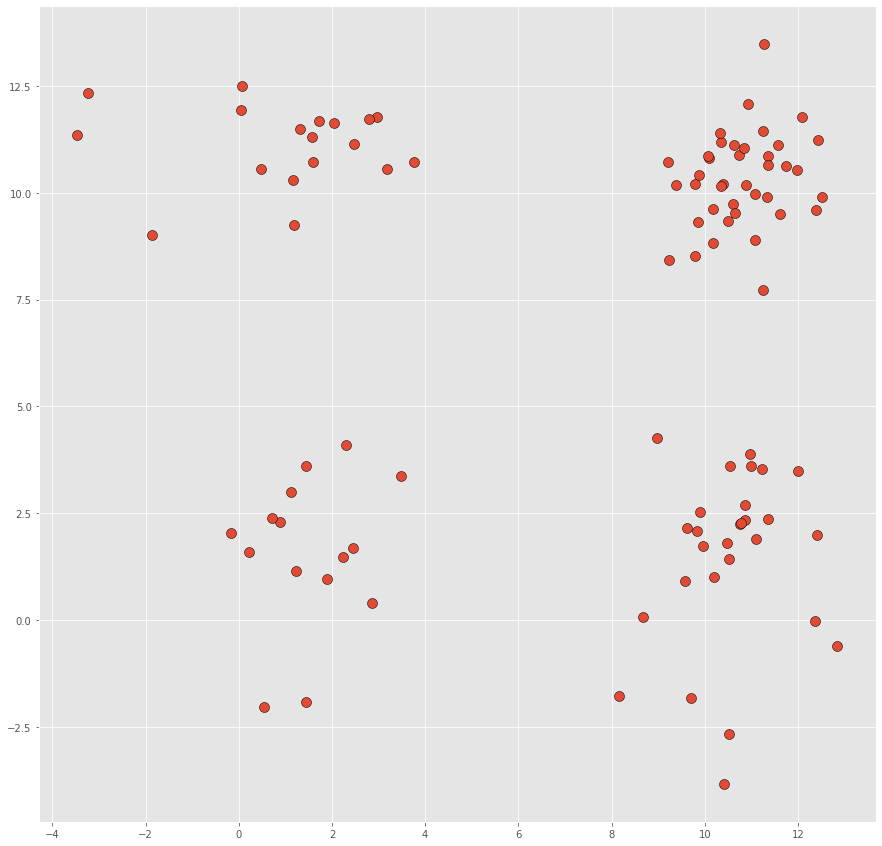

In [51]:
cm_data = ListedColormap(['1.2', '10.2'])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

ax.scatter(df['x'].sample(100), df['y'].head(100),
           cmap=cm_data,
           edgecolors='k',  #colors,
           s=100)

Pandas ``` dataframe.skew()``` function return unbiased skew over requested axis Normalized by N-1. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. For more information on skewness,We check how skwed are the data we have created, by applying the .skew() for x column and y column, correspondingly, and see if it equals to 0. 

In [52]:
df.skew(axis = 0) 

x   -0.556858
y   -0.556453
dtype: float64

In [53]:
from scipy.stats import skew
print(skew(df))

[-0.55685771 -0.55645261]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2d5cabdd8>,
      dtype=object)

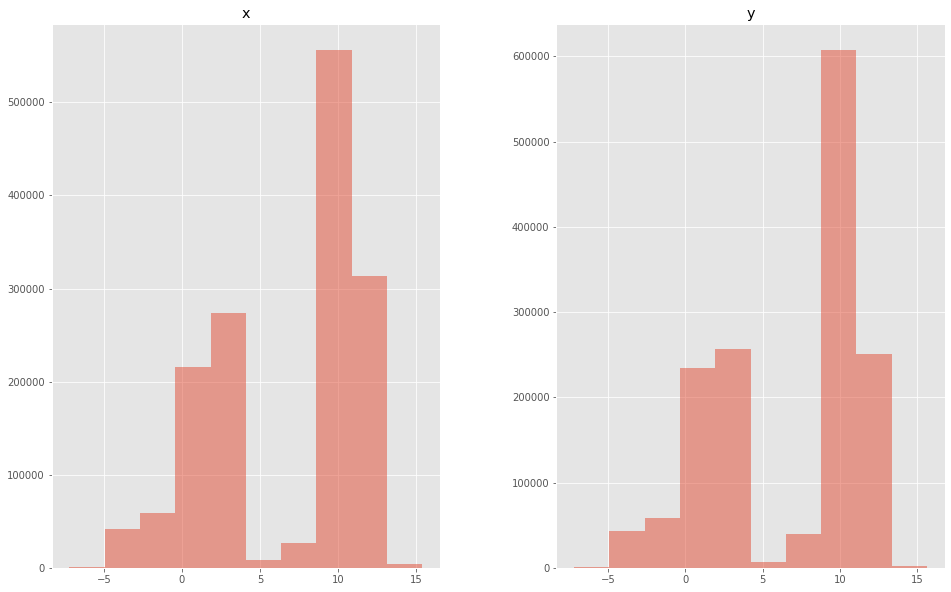

In [54]:
plt.style.use('ggplot')
df.hist(alpha=0.5, figsize=(16, 10))

Uncomment the 2 following cells if only the .txt with the centers and generated data would like to be created and then, in a local directory be saved. 

In [55]:
#df.to_csv(r'data.txt', header=None, index=False, sep=',')

In [62]:
centerdf=pd.DataFrame(centers)
#centerdf.to_csv(r'centers.txt', header=None, index=False, sep=',')

## 3. File in HDFS
The necessary files has been moved to HDFS.

![File has been successfully moved to HDFS](images/movetoHDFS.png)

## 4. MapReduce files

For ruuning k-means in Hadoop we created 5 files; mapper.py, reducer.py, run.sh, centers.txt, data.txt. They are need to be saved in the same directory.
* [centers.txt](centers.txt) file includes three centers (x,y), that k-means algorithm gets as initial centers. These points were selected above in order to create the data file. 
* [data.txt](data.txt) file is the one that was created in the previous chapter
* [mapper.py](mapper.py) contains mapper functions
* [reducer.py](reducer.py) containes reducer functions
* [run.sh](run.sh) is a file created to automate the execution of MapReduce project


#### 4.1 The [mapper.py](mapper.py) file

It reads data from STDIN, split it into words and output a list of lines mapping words to their (intermediate) counts to STDOUT. The Map script will compute the euclidian distance of each coordinate from the center. Then it will find 3 numbers (one for each center). Finally, the minimum will be selected and its index will show to which cluster it belongs.

#### 4.2 The [reducer.py](reducer.py) file

It reads the results of mapper.py from STDIN (so the output format of mapper.py and the expected input format of reducer.py must match) and sum the occurrences of each tuple (x,y) to a final count, and then output its results to STDOUT.

#### 4.3 The [run.sh](run.sh) file

This bash shell script starts MapReduce job in Hadoop. In case we had to illustrate several iterrations of K-means algorithm, each time the shell script executed, new .txt file including centers would be used. The output is saved in hdfs in the hdfs folder `/assignment/output`.

For executing the above files in Hadoop HDFS, first, I was ensured that the file has execution permission (change it with the command ```bash chmod +x /home/hduser/* ```).

## 5. Check and visualize the results

In order to check my .py files, I run on Unix terminal the following pipeline of commands```cat data.txt | python3 mapper.py | sort -k 3 | python3 reducer.py ```. I run the ``` sort ``` command, because Hadoop sorts automatically the mapper result. Then I saved the new centers in a new file [newcenters.txt](newcenters.txt) and I run again the mapper to plot the results of first iterration. 

In [13]:
from math import sqrt
def euclidiandistance(x, y, cx, cy):
    #Calculate euclidian distance between two coordinates
    distance = sqrt(pow(x - cx,2) + pow(y - cy,2))
    return distance

In [14]:
def findcluster(centers,X,Y):
    newarray=[]
    for i in range(0,len(X)-1):
        cluster=-1
        mindist=1000000000
        for center in centers:
            x = X[i]
            y = Y[i]
            dist = euclidiandistance(x,y,center[0],center[1])
            if dist <= mindist:
                mindist = dist
                cluster = centers.index(center)
        newresult = x, y, cluster
        newarray.append(tuple((x, y, cluster)))
    datafr=pd.DataFrame(newarray)
    datafr=datafr.rename(columns={0:'x',1:'y',2:'cluster'})
    return datafr

In [68]:
centers = pd.read_csv('centers.txt', sep=",", header=None)
centers = centers.values.tolist()
centers

[[-2.5, -2.5], [2.0, 2.0], [10.5, 10.5]]

In [56]:
X = df['x'].values
Y = df['y'].values
newdf = findcluster(centers,X,Y)

/home/rafaila/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


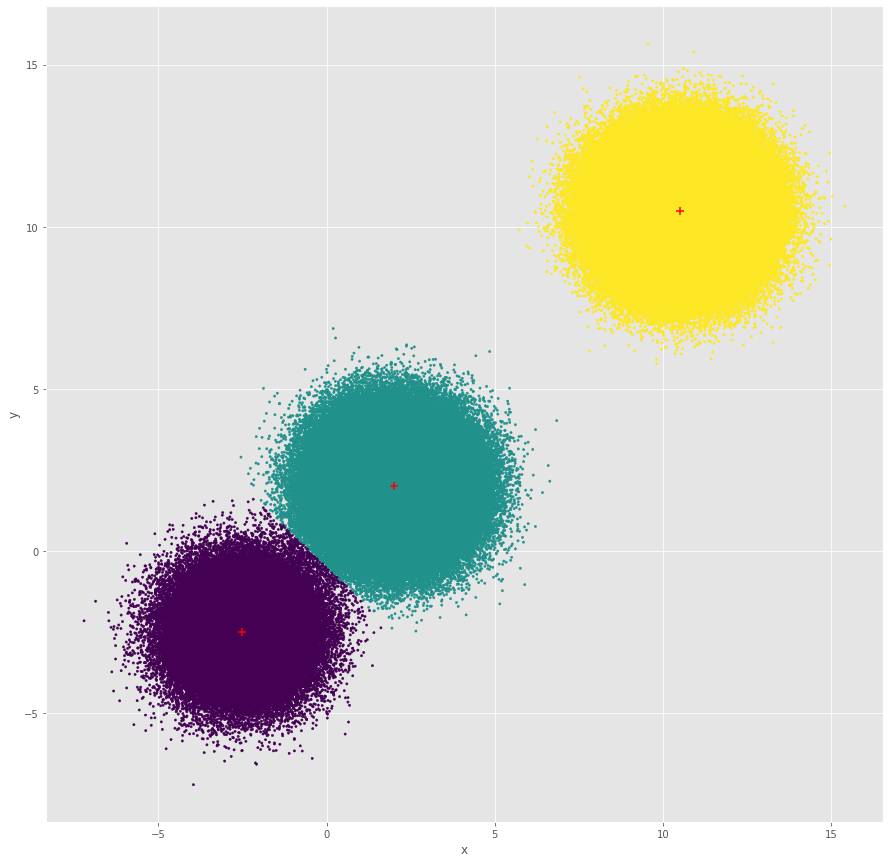

In [57]:
x= newdf['x']
y=newdf['y']
Cluster = newdf['cluster']
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=5)
for i,j in centers:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')


fig.show()

In [65]:
newcenters = pd.read_csv('centers1.txt', sep=",", header=None)
newcenters = newcenters.values.tolist()
newcenters

[[-2.4948023776956276, -2.487853278299609],
 [1.9993587633124743, 1.9995245050658896],
 [10.500493655922996, 10.500747709261287]]

In [66]:
X = newdf['x'].values
Y = newdf['y'].values
newdf1 = findcluster(newcenters,X1,Y1)

/home/rafaila/myvenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


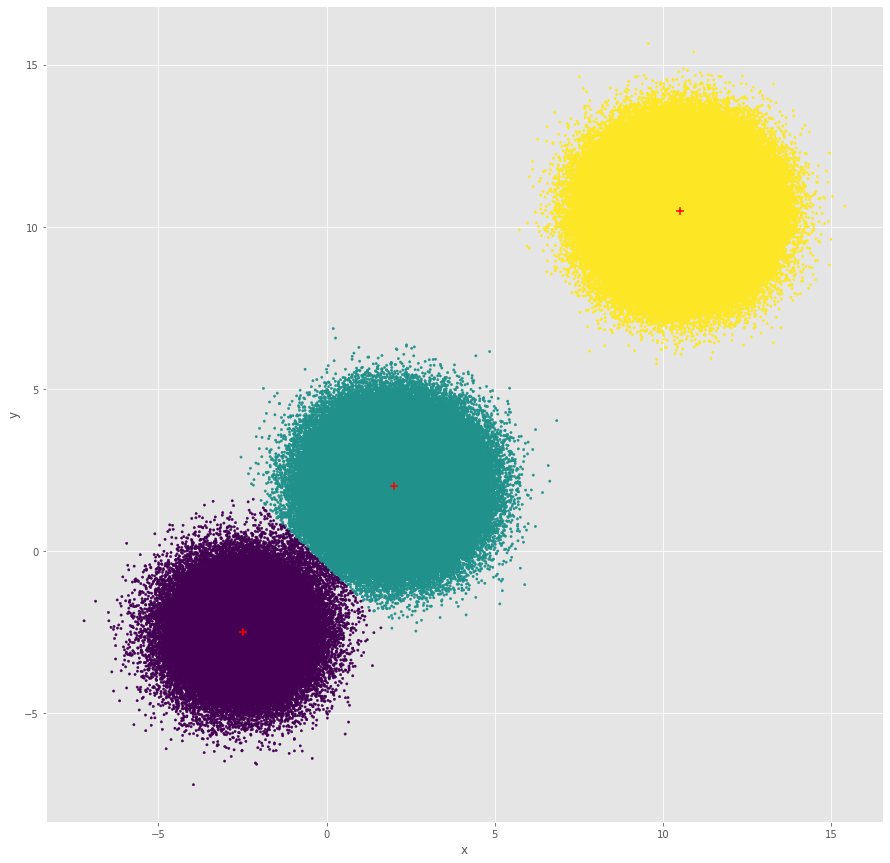

In [67]:
x= newdf1['x']
y=newdf1['y']
Cluster = newdf1['cluster']
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=5)
for i,j in newcenters:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.show()

We see that centers coordinates have a tiny difference, and that is because the data, which have been created using `make_blobs()` function of sklearn API, have a low bias rate.

## References

<a id="1">[1]</a> 
[Writing An Hadoop MapReduce Program In Python](https://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/)

<a id="2">[2]</a> 
Jes ́us Maillo, Isaac Triguero, Francisco Herrera\
A MapReduce-based k-Nearest Neighbor Approachfor Big Data Classification\
2015 IEEE Trustcom/BigDataSE/ISPA DOI 10.1109

<a id="3">[3]</a> 
Ge Song, Justine Rochas, Lea Beze, Fabrice Huet, Frederic Magoules.\
K Nearest Neighbour Joins forBig Data on MapReduce: A Theoretical and Experimental Analysis. \
IEEE Transactions on Knowledgeand Data Engineering, Institute of Electrical and Electronics Engineers, 2016, 28 (9), pp.2376-2392.10.1109/TKDE.2016.2562627. hal-01406473v2

<a id="4">[4]</a>
Max Bodoia
MapReduce Algorithms fork-means Clustering

<a id="5">[5]</a>
[Running Hadoop On Ubuntu Linux (Single-Node Cluster](https://www.michael-noll.com/tutorials/running-hadoop-on-ubuntu-linux-single-node-cluster/)

<a id="6">[6]</a>
[Hadoop Word Count Program](https://www.youtube.com/watch?v=_s4V1XzOCpc)

<a id="7">[7]</a>
Tom White\
Hadoop-The-definite-guide\
O'Reilly Media, Inc. ISBN: 9781491901687  